# BlackJack with Reinforcement Learning Agent

# Problem

##### Here is the brief introduction of the problem..

## Blackjack

<img src="https://upload.wikimedia.org/wikipedia/commons/a/a2/Blackjack_game_1.JPG" width=800 />

Now, we play Blackjack! 
We have improved version of it from OpenAI Gym [Blackjack-V0](https://gym.openai.com/envs/Blackjack-v0/). Our blackjack has an additional betting option. Here follows the rule description. 


### <font color="red"> Game Introduction and Rules: </font>


Blackjack is a card game where the goal is to obtain cards that sum to as
near as possible to 21 without going over.  They're playing against a fixed
dealer.

Face cards (Jack, Queen, King) have point value 10.
Aces can either count as 11 or 1, and it's called 'usable' at 11.
This game is placed with an infinite deck (or with replacement).

The game starts with each player getting two face up cards and dealer
having one face up and face down card and the player needs to bet an 
amount of money within range of 1 to max bet (10). 
Note: Face up means that you will know what the card is.

The player can request additional cards (hit=1) until they decide to stop
(stick=0) or exceed 21 (bust).

After the player sticks, the dealer reveals their facedown card, and draws
until their sum is 17 or greater (fixed policy).  If the dealer goes bust the player wins.
You won't see the dealer's facedown card, just you will know if you have or lost
and you will get appropriate reward of +1 if you win, -1 if you loose or 0 if the match
is drawn.
(It is freedom of choice for you to change the reward function. If you want to change, you should explain the reason of the change.)

If the player wins, the amount he has bet will be doubled and given back. 
If the player and dealer have the same sum, then its a draw and the player will get
back the money he has bet. 
If the player loses then, the money he bet will be lost. 
If neither player nor dealer busts, the outcome (win, lose, draw) is
decided by whose sum is closer to 21. You are free to change the reward function to make it 
learn more efficiently. (i.e.,  the amount of money the user is winning after each round). 

Regardless of the number of players on the table, each player will be just playing against the 
dealer independently of the other players.

## BlackJack Environment

In [2]:
import collections
import numpy as np
import matplotlib.pyplot as plt
import gym
from gym import spaces
from gym.utils import seeding
%matplotlib inline

### Player class definition

Player class defines an object for each BlackJack player with a given *unique* name. It has three attributes, the player's name, current cards in hand, and total balance left to play games.  <code>get_info()</code> is getter method that prints out all three attributes.

In [3]:
class Player():
    """
        
        Player class to create a player object.
        eg: player = Player("player1", start_balance = 10)
        Above declaration will be for your agent.
        All the player names should be unique or else you will get error.
        
    """
    def __init__(self, player_name, start_balance = 10):
        self.player_name = player_name
        self.card = []
        self.starter_balance = start_balance
        self.total_balance = start_balance

    def recharge_account(self):
        self.total_balance = self.starter_balance
        
    def get_info(self):
        print("Player name: {}".format(self.player_name))
        print("Player card: {}".format(self.card))
        print("Player total_balance: {}".format(self.total_balance))     

Following functions are utilities and definition of card deck to play games and to check the game status. 

In [4]:
# 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10
deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]

def cmp(a, b):
    return float(a > b) - float(a < b)

def draw_card(np_random):
    return int(np_random.choice(deck))

def draw_hand(np_random):
    return [draw_card(np_random), draw_card(np_random)]


def usable_ace(hand):  # Does this hand have a usable ace?
    return 1 in hand and sum(hand) + 10 <= 21


def sum_hand(hand):  # Return current hand total
    if usable_ace(hand):
        return sum(hand) + 10
    return sum(hand)


def is_bust(hand):  # Is this hand a bust?
    return sum_hand(hand) > 21


def score(hand):  # What is the score of this hand (0 if bust)
    return 0 if is_bust(hand) else sum_hand(hand)


def is_natural(hand):  # Is this hand a natural blackjack?
    return sorted(hand) == [1, 10]

### Game Environment

The Blackjack game environment is defined as follows. Inheriting, OpenAI.Gym.Env, it overrides the interfances to enable the interfaction with the same interfaces with other OpenAI Gym environments. 

These are important member functions to be used by us:
1. add_player: We can add player object with some initial amount of money

2. step: we need to send the action using this function, actions are hit(1) or stand(0)
        returns {'state': player info and dealer info (_get_obs), 
                 'reward': real-valued reward, 
                 'is_round_done': True/Fasle}
3. _get_obs: returns the state of the env or required information we can use to build your agent. 
             eg: {'player_info':{'player_sum_card': sum of cards, 
                                 'player_card': list of cards, 
                                 'player_total_balance': real-valued number, 
                                 'usable_ace' : True/False}, 
                 'dealer_info': dealer's first card}
4. init_round: will start a new round in the same game.
        returns {'state': player info and dealer info (_get_obs)}
          
5. reset: will reset the whole game and will begin again with the initial balance you had started the player object.
        returns nothing, will just reset the entire game.
          
6. bet_money: we can bet the amount using this method, takes in the money between (1, max_bet_cap). max_bet_cap is 10. 
        returns nothing.


In [5]:


class BlackjackEnv(gym.Env):
    """
    Simple blackjack environment
    
    Blackjack is a card game where the goal is to obtain cards that sum to as
    near as possible to 21 without going over.  They're playing against a fixed
    dealer.
    Face cards (Jack, Queen, King) have point value 10.
    Aces can either count as 11 or 1, and it's called 'usable' at 11.
    This game is placed with an infinite deck (or with replacement).
    The game starts with each (player and dealer) having one face up and one
    face down card.
    The player can request additional cards (hit=1) until they decide to stop
    (stick=0) or exceed 21 (bust).
    After the player sticks, the dealer reveals their facedown card, and draws
    until their sum is 17 or greater.  If the dealer goes bust the player wins.
    If neither player nor dealer busts, the outcome (win, lose, draw) is
    decided by whose sum is closer to 21.  The reward for winning is +1,
    drawing is 0, and losing is -1.
    The observation is: the players current sum, players current card, players balance left, 
    the dealer's one showing card (1-10 where 1 is ace),
    and whether or not the player holds a usable ace (0 or 1).
    
    Parameters
    ==========
    natural      boolean
                 option for 50% more reward on natural blackjack 
    
    """
    
    def __init__(self, natural=False):
        self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Tuple((
            spaces.Discrete(32),
            spaces.Discrete(11),
            spaces.Discrete(2)))
        self.seed()
        self.total_players = 1
        self.players = {}
        self.natural = natural
        self.dealer = []
        self.round_bet_info = {}
        self.max_bet_cap = 10

    def add_player(self, player_class):
        if player_class not in self.players and len(self.players) < self.total_players:
            self.players[player_class.player_name] = player_class
        else:
            raise Exception("Maximum number of player allowed: {}. You can increase the player count while initializing the environment".format(len(self.players)))

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, player_name, action):
        assert self.action_space.contains(action)
        if action:  # hit: add a card to players hand and return
            self.players[player_name].card.append(draw_card(self.np_random))
            if is_bust(self.players[player_name].card):
                done = True
                reward = -1
            else:
                done = False
                reward = 0
        else:  # stick: play out the dealers hand, and score
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(draw_card(self.np_random))
            reward = cmp(score(self.players[player_name].card), score(self.dealer))
            if self.natural and is_natural(self.players[player_name].card) and reward == 1:
                reward = 1.5
        if done:
            self.settle_balance(int(reward), player_name)
        return {'state':self._get_obs(player_name), 'reward': reward, 'is_round_done': done}

    def _get_obs(self, player_name):
        return {'player_info':self.get_player_obs(player_name), 
                'dealer_info': self.dealer[0]}

    def get_player_obs(self, player_name):
        return {'player_sum_card':sum_hand(self.players[player_name].card), 
                'player_card':self.players[player_name].card, 
                'player_total_balance':self.players[player_name].total_balance, 
                'usable_ace' : usable_ace(self.players[player_name].card)}
    
    def get_valid_bet_amount(self, player_name):
        #print("player name: {} money left: {}".format(player_name, self.players[player_name].total_balance))
        if self.players[player_name].total_balance < 1:
            return {'is_round_done': True, 'valid_bet_amount': -1}
        max_bet_upper_limit = self.players[player_name].total_balance
        if self.players[player_name].total_balance >= self.max_bet_cap:
            max_bet_upper_limit = self.max_bet_cap            
        return {'is_round_done': False, 'valid_bet_amount': list(range(1, max_bet_upper_limit+1))}
            
    def init_round(self, player_name):         
        self.dealer = draw_hand(self.np_random)
        self.players[player_name].card = draw_hand(self.np_random)
        return {'state': self._get_obs(player_name)}        

    def bet_money(self, player_name, bet_amount):
        self.players[player_name].total_balance -= bet_amount
        self.round_bet_info[player_name] = bet_amount
            
    def settle_balance(self, is_winner, player_name):
        if is_winner == 1:
            #print("player winner")
            self.players[player_name].total_balance += (2 * self.round_bet_info[player_name])
        elif is_winner == 0:
            #print("Draw match")
            self.players[player_name].total_balance += self.round_bet_info[player_name]
        #else:
            #print("player loser, wont get back the money, try next round")
    
    def reset(self, natural=False):
        for player_name, player_class in self.players.items():
            player_class.recharge_account()
        self.natural = natural
        self.dealer = []
        self.round_bet_info = {}


### Example Run with Random Players

This following code shows how to create an environment and players to play 10 games with 20 maximum rounds. This only includes random betting and random hit/stick decision making. 

In [7]:
env = BlackjackEnv()
player1 = Player('player1')
env.add_player(player1)
#Number of games
number_of_games = 10

#Number of rounds
number_of_rounds = 20

for _game in range(number_of_games):

    env.reset()
    print("-"* 50)
    print("Game Number: {}".format(_game + 1))
    print("-"* 50)
    for _round in range(number_of_rounds): 
        print("%"* 50)
        print("Game Number: {} Round Number: {}".format(_game+1, _round+1))
        print("%"* 50)
        
        #Check if you have enough money left in the account to bet, if not break and start a new game
        valid_bet_flag = env.get_valid_bet_amount(player1.player_name)
        if valid_bet_flag['is_round_done']:
            print("You are out of money ! Will go to next game !!")
            break
        bet_amount = valid_bet_flag['valid_bet_amount']
        
        #Get the observations i.e state and use it to decide how much you want to bet
        round_obs = env.init_round(player1.player_name)
        print("Initial state: {}".format(round_obs))  
        
        # If you have just $1 left in the bank, you have no choice but to bet that amount 
        # and hopefully leave it to the fate for your agent to win and continue playing or just
        # start a new game
        if len(bet_amount) == 1 and bet_amount[0] == 1:
            print("You can only bet 1. So betting only 1.")
            random_bet = 1
        else:
            random_bet = np.random.choice(bet_amount)
        print("Random Init Bet: {}".format(random_bet))
        env.bet_money(player1.player_name, random_bet)
          
        
        # Look at the state and take actions, here the actions are selected randomly
        # you can use the agent to select the action
        random_action = np.random.randint(0, 2)
        print("Action taken: {}".format(random_action))

        #Use the selected action to actually take the action in env by calling step
        round_obs = env.step(player1.player_name, random_action)
        print("State after 1st action: {}".format(round_obs))

        #Check if the game is not over, if your action is stand then the game is over, else
        #the game continues in this loop until your action is stand
        while not round_obs['is_round_done']:
            #Select an random action and take the action
            random_action = np.random.randint(0, 2)
            print("Action taken: {}".format(random_action))
            round_obs = env.step(player1.player_name, random_action)
            print("State after nth action: {}".format(round_obs))

        #Round over, but the game will continue untill you have exhausted your initial money 
        print("Balance Left: {}".format(round_obs['state']['player_info']['player_total_balance']))
        print("Round over")
        print("-%-"*30)
        if (_round + 1) == (number_of_rounds):
            print("Max number of rounds played. If you see this message, you are the winner.")

--------------------------------------------------
Game Number: 1
--------------------------------------------------
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Game Number: 1 Round Number: 1
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
player name: player1 money left: 10
Initial state: {'state': {'player_info': {'player_sum_card': 19, 'player_card': [10, 9], 'player_total_balance': 10, 'usable_ace': False}, 'dealer_info': 6}}
Random Init Bet: 2
Action taken: 1
player loser, wont get back the money, try next round
State after 1st action: {'state': {'player_info': {'player_sum_card': 27, 'player_card': [10, 9, 8], 'player_total_balance': 8, 'usable_ace': False}, 'dealer_info': 6}, 'reward': -1, 'is_round_done': True}
Balance Left: 8
Round over
-%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%-
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Game Number: 1 Round Number: 2
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
player nam

# Methods

## Review of the SARSA and Q-Learning

Temporal Difference(TD) Learning is a Model-Free environment that exploits the Markov Property i.e. the state transition model has Markov property when the future is dependent only on the current state not the past. TD considers that the agent knows only the partial information of the MDP. With only current and next state transition and without any model transition probability, TD lets the agent explore the environment to examine the random policy. We define a Q-function or Q-Table to evaluate the state and action altogether.

We use SARSA and Q-Learning to update the Q values. SARSA is an On-Policy method, which means it computes the Q-value according to a certain policy and then the agent follows that policy. Here is the formula that we use to update Q values in SARSA:

$$
    Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha ( R_{t+1} + \gamma Q(s_{t+1}, a_{t+1}) - Q(s_t, a_t)) 
$$

In Q-learning, we do not make assumption of behavior policy. Thus this is called as off-policy control. Q-learning is similar to SARSA except that when computing Q(s,a) it uses the greedy policy in determining the Q(s’,a’) from the next state s’. However, it does not necessarily follow that greedy policy. Here is the formula that we use to update Q values in Q-Learning:

$$
    Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha ( R_{t+1} + \gamma \max_a Q(s_{t+1}, a) - Q(s_t, a_t)) 
$$

$\alpha \leftarrow$ learning rate   
$\gamma \leftarrow$ discount factor   
$\epsilon \in [0, 1]$, controlling the exploration and exploitation level

Here are the pseudo codes for both these algorithms:

###### **Algorithm: SARSA**
![](http://incompleteideas.net/book/ebook/pseudotmp8.png)


###### **Algorithm: Q-learning**
![](http://incompleteideas.net/book/ebook/pseudotmp9.png)

## Choice of TD learning and Reason

Out of the two TD Learning approaches, I will be using Q-Learning approach for my RL Agent for Blackjack. Both the aproaches are very much similar except for the difference that in SARSA we take actual action and in Q Learning we take the action with highest reward. For the Blackjack problem, our aim is to maximize the rewards, hence I am going the _greedy_ choice. Considering the action with maximum reward would make us reach the goal faster.

However, without new data, greedy action selection will repeat the same actions, or repeatedly *exploit* the current knowledge. Thus, we need to *explore* other non-greedy actions to increase the experience to improve the Q estimation. This is called "**_exploration-exploitation dilemma_**". 

* Exploration : is about finding more information about the environment or exploring a lot of states and actions in the environment.

* Exploitation : is about exploiting the known information to maximize the reward.

Due to exploration problem we don’t act greedily, instead, we use the $\epsilon$-greedy action. With a parameter $\epsilon \in [0, 1]$, we can control the exploration and exploitation level. When $\epsilon = 0$, the actions are selected in greedy manner, but when $\epsilon = 1$, the actions are selected randomly.

Q-learning directly learns the optimal policy, whilst SARSA learns a near-optimal policy whilst exploring. If we want to learn an optimal policy using SARSA, then we will need to decide on a strategy to decay ϵ in ϵ-greedy action choice, which may become a complicated hyperparameter to tune. This is one of the other reason to choose Q-Learning over SARSA.

## Choice of Function Approximation and Reason

Q-learning can be combined with function approximation. This makes it possible to apply the algorithm to larger problems, even when the state space is continuous. Here are the few famous action-value function approximation functions:

* Linear Value
* Neural Network
* Decision Tree
* Nearest Neighbors

I have chosen **Linear Value Function approximation** as it is a differentiable function approximator and converges to global optimum.  It lets us assign values V(s) to states s, which can then be used to determine optimal policies. The performance of Value Iteration with function approximation is going to depend almost entirely on the quality of the features (along with the function representation, i.e. linear, neural network, etc.)

For state transition from $i$ to $j$ with action $k$
$$ V^{n+1} (s_i) = \max_k \Big[ R_i + \gamma \sum_{j=1}^N P^k_{ij} V^n (s_j) \Big] $$

With an estiate of the value function $V(s)$, $\hat{V}(s)$, 

   $$ 
        \begin{align}
        \Rightarrow \quad \delta_t &= R_{t+1} + \gamma \hat{V}(s_{t+1}) - V(s_t).
        \end{align}
    $$
    
We can use this error as a gradient to update the value estimation.

$$
    \begin{align}
        V(s_t) &\leftarrow R_{t+1} + \alpha (R_{t+1} + \gamma \hat{V}(s_{t+1}) - V(s_t))
    \end{align}
$$

Without making assumption of behavior policy, we can explore other possible policies to update the Q.

$$
    Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha ( R_{t+1} + \gamma \max_a Q(s_{t+1}, a) - Q(s_t, a_t)) 
$$

Picking an action can be simple by selecting one with maximum Q value, so *Greedy!*. 

$$
a^* = \arg \max_a Q(S_t, a)
$$

## Implementation of the selected approach (RLAgent)

This is the implementation of RLAgent for the Blackjack game. It consists usual train and test methods and an additional epsilon greedy method to take the action. The model is iterated for the given number of iterations and Q table is updated whenever a new step in algorithm is taken. After each iteration is over, no. of wins, loses, draws are updated. These are used later for calculating the performance of the model. 

A Q-table is built for all state-action pairs and after taking an action at the end of each round of the game, its corresponding entry in the Q-table is updated based on the reward received. The learning process is stopped when the agent has sufficiently explored the environment. At this point, we would have the optimized Q-table which is the strategy the agent has learned to play blackjack.

###### RLAgent for Blackjack

The implementation of the RLAgent for Blackjack goes like this:

In [6]:
from collections import defaultdict

class RLAgent: 
    """
        Reinforcement Learning Agent Model for training/testing
       using Q-Learning
        
    """
    
    def __init__(self, env):
        self.env = env
        #number of actions
        self.nA = self.env.action_space.n
        #Initialise Q-Table
        self.Q = defaultdict(lambda: np.zeros(self.nA))
    
    # greedy action selection
    def greedy(self, Q, state):
        return np.argmax(self.Q[state])  
    
    #epsilon greed function
    def epsilon_greed(self, epsilon, state):
        print(state)
        if np.random.rand() < epsilon:
            return np.random.randint(self.nA)
        else:
            return self.greedy(self.Q, state)
    
    #Slicing the state to use for Q-table update. 
    #I am maintaining player card sum, dealer card info and usable ace to store in Q-table
    def sliceState(self,state):
        state = tuple((state['player_info']['player_sum_card'], state['dealer_info'], state['player_info']['usable_ace']))
        return state

    def train(self,player1, **params):
        self.player1 = player1
        
        # parameters
        gamma = params.pop('gamma', 0.99)
        alpha = params.pop('alpha', 0.1)
        epsilon= params.pop('epsilon', 0.1)
        maxiter= params.pop('maxiter', 1000) #no. of games
        maxstep= params.pop('maxstep', 1000) #no. of rounds

        #Add player
        #player1 = Player('player1')
        #env.add_player(player1)        
        
        #online train
        #initialise rewards trace
        rtrace = []
        
        for j in range(maxiter):
            self.env.reset()
            
            #initialise rewards and trace as an empty list
            rewards = []
            trace = []
            
            # run simulation for max number of steps 
            for step in range(maxstep): 
        
                #Check if you have enough money left in the account to bet, if not break and start a new game
                valid_bet_flag = self.env.get_valid_bet_amount(player1.player_name)
                if valid_bet_flag['is_round_done']:
                    break
                bet_amount = valid_bet_flag['valid_bet_amount']

                #Get the observations i.e state and use it to decide the bet amount
                state = self.env.init_round(player1.player_name)
                
                #slice the state to get required info only
                state = self.sliceState(state['state'])

                # If you have just $1 left in the bank, ALL-IN 
                if len(bet_amount) == 1 and bet_amount[0] == 1:
                    bet = 1
                else:
                    bet = np.random.choice(bet_amount)
                    self.env.bet_money(player1.player_name, bet)

                #Select action
                action = self.epsilon_greed(epsilon, state)
                
                while True:
                    #Use the selected action to actually take the action in env by calling step
                    result = self.env.step(player1.player_name, action)
                    
                    #Fetch the state, reward and done from result
                    next_state, reward, done = result['state'], result['reward'], result['is_round_done']
                    next_state = self.sliceState(next_state)
                    
                    #Select the next action
                    next_action = self.epsilon_greed(epsilon,next_state)
                    trace.append(next_state)
                    rewards.append(reward)

                    #update the Q-table using Q-learning algorithm
                    self.Q[state][action] = self.Q[state][action] + ( alpha * ( (reward + (gamma * np.max(self.Q[next_state]))) - self.Q[state][action] ) )    
                    
                    state = next_state
                    action = next_action
                    if done:
                        break

            rtrace.append(np.sum(rewards))
        return rtrace, trace

    def test(self, maxiter=1000):
        epsilon = 0
        #Initialise counters to track win, loss and draw
        win = 0
        lose = 0
        draw = 0
        
        # rewards trace
        rtrace = []
        trace = []
        
        #keeping track of number of rounds
        rounds = 0
        
        for j in range(maxiter):         
            self.env.reset()
            
            #Checking if we have enough money left in the account to bet, if not break and start a new game
            valid_bet_flag = self.env.get_valid_bet_amount(self.player1.player_name)
            if valid_bet_flag['is_round_done']:
                break
            bet_amount = valid_bet_flag['valid_bet_amount']

            #Get the observations i.e state and use it to decide how much to bet
            state = self.env.init_round(self.player1.player_name)

            #slice the state to get required info only
            state = self.sliceState(state['state'])

            # If you have just $1 left in the bank, ALL-IN 
            if len(bet_amount) == 1 and bet_amount[0] == 1:
                bet = 1
            else:
                bet = np.random.choice(bet_amount)
                self.env.bet_money(self.player1.player_name, bet)

            #Select action
            action = self.epsilon_greed(epsilon, state)
          
            rewards = []
            
            while True :
                #Use the selected action to actually take the action in env by calling step
                result = self.env.step(self.player1.player_name, action)
                
                next_state, reward, done = result['state'], result['reward'], result['is_round_done']
                next_state = self.sliceState(next_state)
                next_action = self.epsilon_greed(epsilon,next_state)
                trace.append(next_state)
                rewards.append(reward)

                state = next_state
                action = next_action
                rounds += 1

                if(reward>0):
                    win = win + 1
                elif(reward<0):
                    lose = lose + 1
                else:
                    draw = draw + 1

                if done:
                    break
                    
            rtrace.append(np.sum(rewards))
        
        #print("\n No. of rounds Won :  {}  Lost : {}  Draw : {}".format(win,lose,draw))
        #print("\n Win Percentage",(win*100)/rounds, "%")
        #print("\n Lose Percentage",(lose*100)/rounds, "%")
        #print("\n Draw Percentage",(draw*100)/rounds, "%")
        
        return rtrace, trace,  ((win*100)/rounds)           

##### Testing the agent without changing any hyperparameters and running all defaults

In [97]:
env = BlackjackEnv()
player1 = Player('player1')
env.add_player(player1)
agent =  RLAgent(env)
rtrace, trace = agent.train(player1)

In [102]:
rtrace_test, trace_test, win = agent.test()
#total rewards after each iteration
rtrace_test

[-1.0,
 1.0,
 0.0,
 1.0,
 -1.0,
 -1,
 -1,
 1.0,
 -1,
 -1.0,
 -1.0,
 1.0,
 0.0,
 -1.0,
 1.0,
 1.0,
 -1,
 1.0,
 -1,
 -1,
 1.0,
 0.0,
 -1.0,
 1.0,
 1.0,
 -1.0,
 -1,
 1.0,
 -1.0,
 -1.0,
 -1.0,
 -1,
 -1.0,
 1.0,
 -1,
 -1,
 0.0,
 1.0,
 -1.0,
 1.0,
 0.0,
 -1.0,
 -1,
 1.0,
 -1,
 1.0,
 -1,
 -1.0,
 -1,
 -1,
 -1.0,
 -1,
 -1.0,
 -1,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 -1,
 0.0,
 -1,
 -1,
 -1.0,
 -1,
 1.0,
 1.0,
 -1.0,
 1.0,
 0.0,
 -1,
 -1,
 1.0,
 1.0,
 -1,
 -1,
 1.0,
 1.0,
 -1.0,
 -1,
 1.0,
 0.0,
 1.0,
 -1,
 1.0,
 1.0,
 -1,
 -1.0,
 -1.0,
 1.0,
 1.0,
 1.0,
 -1,
 -1.0,
 1.0,
 -1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 -1,
 -1,
 -1.0,
 0.0,
 -1,
 1.0,
 -1,
 -1,
 0.0,
 0.0,
 1.0,
 -1,
 -1.0,
 1.0,
 -1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 -1.0,
 1.0,
 -1.0,
 1.0,
 -1,
 -1.0,
 1.0,
 -1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 -1,
 -1,
 0.0,
 -1,
 1.0,
 -1,
 1.0,
 0.0,
 -1,
 1.0,
 -1,
 1.0,
 1.0,
 0.0,
 0.0,
 -1,
 1.0,
 1.0,
 -1.0,
 1.0,
 -1,
 0.0,
 1.0,
 -1.0,
 -1,
 -1.0,
 -1,
 -1,
 1.0,
 0.0,


In [103]:
trace_test

[(20, 3, False),
 (20, 3, False),
 (20, 2, False),
 (20, 3, False),
 (15, 6, False),
 (21, 6, False),
 (21, 6, False),
 (19, 10, False),
 (19, 10, False),
 (23, 4, False),
 (22, 1, False),
 (19, 9, False),
 (19, 9, False),
 (22, 3, False),
 (18, 10, False),
 (18, 10, False),
 (16, 4, False),
 (18, 4, False),
 (18, 4, False),
 (9, 4, False),
 (18, 7, False),
 (17, 8, False),
 (20, 7, False),
 (21, 7, True),
 (28, 1, False),
 (20, 7, True),
 (20, 7, True),
 (27, 1, False),
 (25, 10, False),
 (19, 8, False),
 (19, 8, False),
 (18, 10, False),
 (18, 10, False),
 (13, 2, False),
 (15, 2, False),
 (16, 2, False),
 (19, 2, False),
 (19, 2, False),
 (12, 10, False),
 (12, 10, False),
 (13, 10, False),
 (13, 10, False),
 (16, 2, True),
 (15, 2, False),
 (25, 2, False),
 (17, 10, False),
 (21, 10, False),
 (21, 10, False),
 (13, 10, False),
 (12, 10, False),
 (19, 3, False),
 (19, 3, False),
 (23, 2, False),
 (20, 1, False),
 (13, 2, False),
 (21, 2, False),
 (21, 2, False),
 (24, 6, False),
 (2

In [40]:
#Win percentage -- calculated by total number of rounds won by total rounds in 1000 iterations
print("Win :", win,"%")

Win : 21.75208581644815 %


## Explanation of the codes

The implementation of the RL Agent was simple consisting for below main functions. The code implementaton is done for the Q-Learning approach that we discussed already. This includes the greedy action taken by Q-Learning.

Here are the main simulation functions of RL Agent class:

__init__ $\rightarrow$ We initialise the Q-Table with all zero values. Using the formula, we will update this table for every new action taken by the algorithm.

**greedy** $\rightarrow$ We pick an action that can be simple by selecting one with maximum Q value, so Greedy!

**epsilon_greed** $\rightarrow$ We use the $\epsilon$_greedy action selection to control the exploration-exploitation dilemma. With a parameter  $\epsilon$ ∈ [0,1] , we can control the exploration and exploitation level. When  $\epsilon$ = 0 , the actions are selected in greedy manner, but when  𝜖=1 , the actions are selected randomly.

**sliceState** $\rightarrow$ To slice the state that is returned by get_player_obs and using the info that we need to store in Q-table.

**train** $\rightarrow$ Train function actively collect data while interacting with Blackjack environment and update its Q-table with Q-Learning. The model will be trained with various values of learning rate, discount factor and epsilon keeping the others constant. The best output parameter is taken in each case and corresponding model is trained.

**test** $\rightarrow$ We use the computed Q estimation in train function to test with environment and use it to take action for the test run of 1000 games. We also calculate the win percentage over the total rounds played in 1000 iterations. I will be using this as a metric to tune my hyperparameters.

# Experimental Outputs for Hyperparameters Selection & Output Plots

## Experiment 1 : Learning Rate ($\alpha$)

In the train method, we have used constant learning rate, $\alpha$ = 0.1 

Now we will try out different learning rates find out the best win percentage for our RLAgent. We are keeping the other parameters as default.

In [119]:
#Different values of gamma to be tested
alpha = [0.0001,0.001,0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]

env_1 = BlackjackEnv()
player1a = Player('player1')
env_1.add_player(player1a)
agent_1 = RLAgent(env_1)

#initialise win array to store win results
win_alpha = []
for i in alpha:
    rtrace,trace = agent_1.train(player1a,alpha=i)
    rtrace_test, trace_test, win = agent_1.test()
    win_alpha.append(win)
    print("Alpha : {} \t Win Percentage : {} %".format(i,round(win,2)))


Alpha : 0.0001 	 Win Percentage : 26.65 %
Alpha : 0.001 	 Win Percentage : 26.91 %
Alpha : 0.01 	 Win Percentage : 24.94 %
Alpha : 0.1 	 Win Percentage : 23.47 %
Alpha : 0.2 	 Win Percentage : 26.88 %
Alpha : 0.3 	 Win Percentage : 26.96 %
Alpha : 0.4 	 Win Percentage : 28.99 %
Alpha : 0.5 	 Win Percentage : 32.0 %
Alpha : 0.6 	 Win Percentage : 28.53 %
Alpha : 0.7 	 Win Percentage : 31.55 %
Alpha : 0.8 	 Win Percentage : 30.89 %
Alpha : 0.9 	 Win Percentage : 31.38 %
Alpha : 1 	 Win Percentage : 29.3 %


Text(0, 0.5, 'Win %')

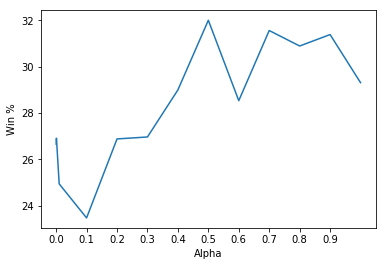

In [120]:
#Plotting the results for Alpha test
plt.plot(alpha,win_alpha)
plt.xticks(np.arange(0,1,0.1))
plt.xlabel("Alpha")
plt.ylabel("Win %")

###### We get the best win percentage of 32% with $\alpha$ = 0.5

## Experiment 2 : Discount Factor ($\gamma$)

In the train method, we have used constant discount factor, $\gamma$ = 0.99

Now we will try out different discount factors find out the best win percentage for our RLAgent. We are keeping the other parameters as default.

In [123]:
#Different values of gamma to be tested
gamma = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]

env_2 = BlackjackEnv()
player1g = Player('player1')
env_2.add_player(player1g)
agent_2 = RLAgent(env_2)

#initialise win array to store win results
win_gamma = []
for i in gamma:
    rtrace,trace = agent_2.train(player1g,gamma=i)
    rtrace_test, trace_test, win = agent_2.test()
    win_gamma.append(win)
    print("Gamma : {} \t Win Percentage : {} %".format(i,round(win,2)))


Gamma : 0.1 	 Win Percentage : 29.98 %
Gamma : 0.2 	 Win Percentage : 27.44 %
Gamma : 0.3 	 Win Percentage : 24.71 %
Gamma : 0.4 	 Win Percentage : 24.76 %
Gamma : 0.5 	 Win Percentage : 23.89 %
Gamma : 0.6 	 Win Percentage : 21.48 %
Gamma : 0.7 	 Win Percentage : 22.25 %
Gamma : 0.8 	 Win Percentage : 23.71 %
Gamma : 0.9 	 Win Percentage : 24.24 %
Gamma : 1 	 Win Percentage : 24.35 %


Text(0, 0.5, 'Win %')

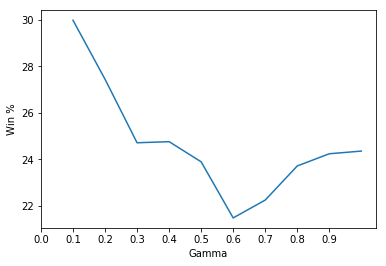

In [124]:
#Plotting the results for Gamma test
plt.plot(gamma,win_gamma)
plt.xticks(np.arange(0,1,0.1))
plt.xlabel("Gamma")
plt.ylabel("Win %")

###### We get the best win percentage of 29.98 % with $\gamma$ = 0.1

## Experiment 3 : Epsilon ($\epsilon$)

In the train method, we have used constant epsilon, $\epsilon$ = 0.1

Now we will try out different discount factors find out the best win percentage for our RLAgent. We are keeping the other parameters as default.

In [127]:
#Different values of epsilon to be tested
epsilon = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

env_3 = BlackjackEnv()
player1e = Player('player1')
env_3.add_player(player1e)
agent_3 = RLAgent(env_3)

#initialise win array to store win results
win_epsilon = []
for i in epsilon:
    rtrace,trace = agent_3.train(player1e,epsilon=i)
    rtrace_test, trace_test, win = agent_3.test()
    win_epsilon.append(win)
    print("Epsilon : {} \t Win Percentage : {} %".format(i,round(win,2)))


Epsilon : 0.1 	 Win Percentage : 24.82 %
Epsilon : 0.2 	 Win Percentage : 23.41 %
Epsilon : 0.3 	 Win Percentage : 25.17 %
Epsilon : 0.4 	 Win Percentage : 27.47 %
Epsilon : 0.5 	 Win Percentage : 28.64 %
Epsilon : 0.6 	 Win Percentage : 27.14 %
Epsilon : 0.7 	 Win Percentage : 29.29 %
Epsilon : 0.8 	 Win Percentage : 26.23 %
Epsilon : 0.9 	 Win Percentage : 27.56 %


Text(0, 0.5, 'Win %')

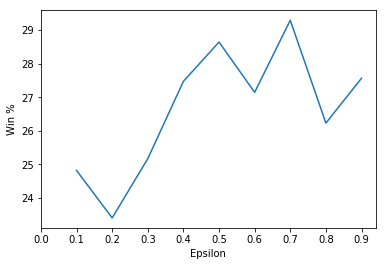

In [128]:
#Plotting the results for Epsilon test
plt.plot(epsilon,win_epsilon)
plt.xticks(np.arange(0,1,0.1))
plt.xlabel("Epsilon")
plt.ylabel("Win %")

###### We get the best win percentage of 29.29 % with $\epsilon$ = 0.7

## Experiment 4 : Maximim Iterations(maxiter)

In the train method, we have used constant maxiter of 1000.

Now we will try out different number of iterations and find out the best win percentage for our RLAgent. We are keeping the other parameters as default.

In [130]:
#Different vlaues of maxiter to be tested
maxiter = [50,100,200,500,1000,2000,5000]

env_4 = BlackjackEnv()
player1m = Player('player1')
env_4.add_player(player1m)
agent_4 = RLAgent(env_4)

#initialise win array to store win results
win_maxiter = []
for i in maxiter:
    rtrace,trace = agent_4.train(player1m,maxiter=i)
    rtrace_test, trace_test, win = agent_4.test()
    win_maxiter.append(win)
    print("maxiter : {} \t Win Percentage : {} %".format(i,round(win,2)))

maxiter : 50 	 Win Percentage : 24.28 %
maxiter : 100 	 Win Percentage : 25.21 %
maxiter : 200 	 Win Percentage : 23.72 %
maxiter : 500 	 Win Percentage : 22.05 %
maxiter : 1000 	 Win Percentage : 24.06 %
maxiter : 2000 	 Win Percentage : 25.58 %
maxiter : 5000 	 Win Percentage : 27.45 %


Text(0, 0.5, 'Win %')

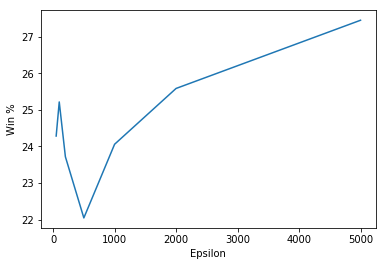

In [131]:
#Plotting the results for maxiter test
plt.plot(maxiter,win_maxiter)
plt.xlabel("Epsilon")
plt.ylabel("Win %")

###### We get the best win percentage of 27.45 % with maxiter = 5000

## Experiment 5 : Maximim Steps(maxstep)

In the train method, we have used constant maxstep of 1000.

Now we will try out different number of steps and find out the best win percentage for our RLAgent. We are keeping the other parameters as default.

In [132]:
#Different vlaues of maxiter to be tested
maxstep = [50,100,200,500,1000,2000]

env_5 = BlackjackEnv()
player1s = Player('player1')
env_5.add_player(player1s)
agent_5 = RLAgent(env_5)

#initialise win array to store win results
win_maxstep = []
for i in maxstep:
    rtrace,trace = agent_5.train(player1s,maxstep=i)
    rtrace_test, trace_test, win = agent_5.test()
    win_maxstep.append(win)
    print("maxstep : {} \t Win Percentage : {} %".format(i,round(win,2)))

maxstep : 50 	 Win Percentage : 21.72 %
maxstep : 100 	 Win Percentage : 23.63 %
maxstep : 200 	 Win Percentage : 22.84 %
maxstep : 500 	 Win Percentage : 24.73 %
maxstep : 1000 	 Win Percentage : 25.25 %
maxstep : 2000 	 Win Percentage : 26.85 %


Text(0, 0.5, 'Win %')

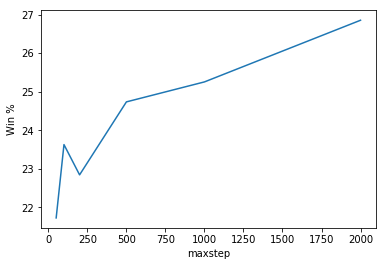

In [133]:
#Plotting the results for maxstep test
plt.plot(maxstep,win_maxstep)
plt.xlabel("maxstep")
plt.ylabel("Win %")

###### We get the best win percentage of 26.85 % with maxiter = 2000

## Reports the selected parameters

Here is the summary of report of selected parameters that we get after running all the experiments for all hyper parameters:

|**Hyperparameter**       | **Value**    | **Best Win Percentage**      | 
|-------------------------|--------------|------------------------------|
|Learning Rate, $\alpha$  |    0.5       |32.0 %                        |
|Discount Factor, $\gamma$|    0.1       |29.98 %                       |
|Epsilon, $\epsilon$      |    0.7       |29.29 %                       |
|maxiter                  |    5000      |27.45 %                       |
|maxstep                  |    2000      |26.85 %                       |

###### I will be running one final experiment using Sklearn's ParameterGrid to find out the best hyperparameters for our RLAgent keeping the maxiter & maxstep as 1000

In [134]:
from sklearn.model_selection import ParameterGrid
from copy import copy
import warnings
warnings.filterwarnings('ignore')

#Dictionary of all hyperparameters will possible values to be tested
params_grid = { 'alpha' : [0.001,0.01,0.1,0.2,0.4,0.5,0.6,0.7,0.8,0.9], 'gamma' : [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9], 'epsilon' : [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9] } 
#Creating a grid list using ParameterGrid
grid_list = list(ParameterGrid(params_grid))

#Creating Environment
env_grid = BlackjackEnv()
player1grid = Player('player1')
env_grid.add_player(player1grid)
agent_grid = RLAgent(env_grid)

#initialise win array to store win results
win_grid = []

#Running for all the possible combinations of hyperparameters
for k in range(len(grid_list)):
    rtrace,trace = agent_grid.train(player1grid,**grid_list[k])
    rtrace_test, trace_test, win = agent_grid.test()
    win_grid.append(win)
    
    #Storing the first results in best_win & best_grid parameters and using it for future comaprisions
    if k == 0:
        best_win = copy(win_grid[k])
        best_grid = copy(grid_list[k])
    elif win_grid[k] > best_win:
        best_win = copy(win_grid[k])
        best_grid = copy(grid_list[k])

#Print the best win percentage and best parameters that provide these resullts
print("Best Win : ", best_win,"%")
print("Best Parameters : ", best_grid)

Best Win :  31.93717277486911 %
Best Parameters :  {'alpha': 0.8, 'epsilon': 0.7, 'gamma': 0.9}


Now, we will use the parameters that we got using 5 individiual experiments and compare them with the grid test results obtained above.

In [135]:
#Running the agent with best hyperparamters of individual experiments
env_f = BlackjackEnv()
player1f = Player('player1')
env_f.add_player(player1f)
agent_f = RLAgent(env_f)
rtrace,trace = agent_f.train(player1f,epsilon=0.7,alpha = 0.5, gamma =0.1, maxiter = 5000, maxstep = 2000 )
rtrace_test, trace_test, win = agent_f.test()
print("Win  :", win,"%")

Win  : 26.561472715318867 %


In [7]:
#Running the agent with best hyperparamters of ParameterGrid Experiment
env_f = BlackjackEnv()
player1f = Player('player1')
env_f.add_player(player1f)
agent_f = RLAgent(env_f)
rtrace,trace = agent_f.train(player1f,epsilon=0.7,alpha = 0.8, gamma =0.9 )
rtrace_test, trace_test, win = agent_f.test()
print("Win  :", win,"%")

NameError: name 'env' is not defined

So, we get the best win percentage of 30.80% with :  
Best Parameters :  {'alpha': 0.8, 'epsilon': 0.7, 'gamma': 0.9}

## More Output plots for BlackJack

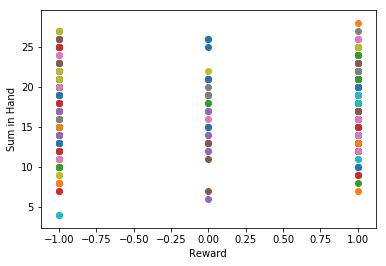

In [146]:
plt.xlabel("Reward")
plt.ylabel("Sum in Hand")
for i in range(500):
    plt.scatter(rtrace_test[i], trace_test[i][0])

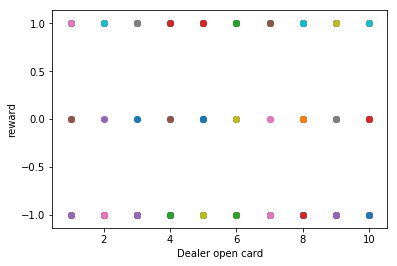

In [147]:
#Rewards for various Dealer open Card
plt.xlabel("Dealer open card")
plt.ylabel("reward")
for i in range(500):
    plt.scatter(trace_test[i][1],rtrace_test[i])

## Reading and Analysis of learning results and plots

In this section, I will explain about the experiments that I ran to find out the best hyperparameters. i have used win percentage as my metric to decide for what value of hyperparameter, agent is performing best.

###### Learning Rate
I tried various learning rates $\alpha$ betweeen 0.001 to 1 and recorded the win percentage for each one of them. I got the best result for ** $\alpha$  = 0.5 ** However, for other values win percentage was close by. So, we needed to tune other hyperparameters along with best value of $\alpha$.

##### Discount Factor & Epsilon
Similarly for discount factor $\gamma$  and $\epsilon$, I tried values in range 0 to 1 and got the best results for $\gamma$  = 0.1 When I increased the values, I saw the agent was not learning well enough and the win percentage was getting dropped. Hence, I decided for **$\gamma$  = 0.1**
The similar experiment when done with $\epsilon$ provided best results for **$\epsilon$ = 0.7** which is more toward the random action than a greedy choice of action in epsilon_greed fucntion

##### Maxiter & Maxstep
We ran all these experiments for the default value of 1000 iterations and 1000 steps which means 1000 games and 1000 rounds of training. I tried to play around with these number of iterations and found out that when we have more iterations, we get better results. Maybe, I would have got better results for more iterations, but due to computational complexities, I restricted my experimentation to 5K iterations. These are the best values that I got with these experiments :  
**maxiter = 5000**  
**maxstep = 2000**


##### ParameterGrid
Once I got all the best hyperparamters after each individual experiment, I decided to combine these results and find out best hyperparameters when these are taken together. So achieve this, I used ParameterGrid from sklearn which creates a grid_list of all possible combinations. I used 10 different values of $\alpha$ , 9 fifferent values of $\gamma$ & $\epsilon$ which resulted in (10*9*9) 810 different combinations. This was computationally challenging took almost an hour to run. Once it ran successfully, I got Best Parameters :  {'alpha': 0.8, 'epsilon': 0.7, 'gamma': 0.9} combination. For this experiment, I used default iterations and steps of 1000, else it would have been very time consuming.

**This is how I decided the best hyperparamters for our RLAgent and it resulted in 30.8 % Win.**

# Conclusion

Here are some key highlights of my learning during this exercise:

- Blackjack is a card game where the goal is to obtain cards that sum to as near as possible to 21 without going over. They're playing against a fixed dealer. I had never played this game before though I usually play card games. I spent inital days in understanding this game and watched many Youtube videos to understand how betting is done and how a round/game is won. This is very interesting!  
<br>

- In this exercise, a learning agent successfully learned how to play blackjack and evaluate the win percentage(I used the number of rounds won the player over total rounds played in 1000 games). Q-learning was used by the agent to continuously update its Q-table during the learning process based on the action taken and the corresponding reward received. The rate at which the agent learns was proportional to the value of its learning rate, alpha which was initially set to 0.1. The agent first explored the environment rapidly by taking random decisions before relying on its Q-table to make appropriate decisions. This behavior was controlled by the agent's exploration factor, epsilon, which was initially set to 0.1   
<br>

- I ran multiple experiments to find out best hyperparamters and it helped me understand how Q-Table is getting updated and how agent learns. However, testing with multiple parameters took a lot of time. 
<br>

- Finally, it was very interesting to see a simple Q-Learning algorithm learn a satisfactory strategy to play blackjack.

# References

[1]  Steeve Huang. "Introduction to Various Reinforcement Learning Algorithms. Part I (Q-Learning, SARSA, DQN, DDPG)", Towards Data Science, Jan 12 2018,
https://towardsdatascience.com/introduction-to-various-reinforcement-learning-algorithms-i-q-learning-sarsa-dqn-ddpg-72a5e0cb6287

[2] Hunter, J. D. "Matplotlib: A 2D graphics environment",Computing In Science \& Engineering, IEEE COMPUTER SOC, 9, 90-95 (2007),
https://matplotlib.org/tutorials/introductory/sample_plots.html

[3] Travis E, Oliphant. A guide to NumPy, USA: Trelgol Publishing, (2006),
http://www.numpy.org/

[4] Aurélien Géron, "_Hands on Machine learning with scikit learn and Tensorflow_", O'Reilly Media, 2017

[5] Pranav Mahajan. "Playing Blackjack using Model-free Reinforcement Learning in Google Colab!", Towards Data Science, Jan 14 2019,
https://towardsdatascience.com/playing-blackjack-using-model-free-reinforcement-learning-in-google-colab-aa2041a2c13d

[6] "Q-learning”: From Wikipedia, the free encyclopedia, from 
https://en.wikipedia.org/wiki/Q-learning
